*notebook author : HAZEM DHAOU*

#Detect total amount TTC on receipt image with deep learning 

The goal of this notebook is to create and train a deep learning model with data from **CORD: A Consolidated Receipt Dataset for Post-OCR Parsing**.


Since this is a localization problem , i decided to train a **FASTER-RCNN** model which predicts a bounding box around the total amount of TTC in a reciapt image and then and OCR will be used to extract a amount of money in that region .


I use Pytorch framework to train the model since it's easier to debug and more pythonic than tensorflow

The notebook is devided into the following chapters 
1. Loading libraries and setting working directory
2. Loading and cleaning the data  
3. Building the model 
4. Training the model 
5. Visualize predictions and Post processing
6. Conclusion


 


###1 - Importing libraries and setting working directory


In [ ]:
#importing libraries
%matplotlib inline
import torch
import torch.utils.data 
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import math
import sys
import time

import numpy as np
import os
import json
from PIL import Image,ImageOps
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import os
import random
import glob
from google.colab import drive
from tqdm.notebook import tqdm

The data consists of the labeled (json file containing bbox of reciept elements) image from the CORD dataset (1000 images) which devided into train set,dev set and test set .

I put the datasets in my personal drive in a folder named **CORD**.

In [ ]:
#mounting the personal drive 
drive.mount('/content/drive/')

In [ ]:
#changing the current working directory
os.chdir("/content/drive/MyDrive/CORD/")

Installing necessary packages to train the model

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


installing pycocotools and tesseract

In [ ]:
!pip install pycocotools
!sudo apt install tesseract-ocr
!pip install pytesseract


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

###2 - Loading and cleaning the data 


In [ ]:
#Getting dataset image file paths 
train_im_files = sorted(list(glob.glob('train/image/*')))
test_im_files = sorted(list(glob.glob('test/image/*')))
dev_im_files = sorted(list(glob.glob('dev/image/*'))) 
#Getting dataset json file paths 
train_json_files =sorted(list(glob.glob('train/json/*'))) 
test_json_files = sorted(list(glob.glob('test/json/*'))) 
dev_json_files = sorted(list(glob.glob('dev/json/*'))) 

print("Available training images in the dataset :",len(train_im_files),"images")
print("Available test images in the dataset :",len(test_im_files),"images")
print("Available dev images in the dataset :",len(dev_json_files),"images")


After a quick check of all the json files , i noticed that there exist json files without the category of **total.total_price** so the bbox coordinates of the TTC price are missing , these files will be discarded as their number is not big 

In [ ]:
def clean_dataset(images_files,json_files):

  """function that removes files without information or with incomplete information about the total price bbox """

  clean_img_data=[] # initializing list of images paths without unwanted files
  clean_json_data=[] # initializing list of json paths without unwanted files
  for img_file ,json_file in tqdm(zip(images_files,json_files)):
    tmp=[]
    with open(json_file, 'r') as info_file: #reading json file 
      data = json.load(info_file) #getting the data from json file
      valid=data["valid_line"] #accessing the valid entries which has
      for info in valid:
        if  "total.total_price" in info['category'] : #check if the entry has the total.total_price category 
          tmp.append(info)
      if len(tmp)==0 : #if the file doesn't contain
        continue
      elif len(tmp)==1 and len(tmp[0]["words"])==1:
        continue
      else:
        clean_img_data.append(img_file)
        clean_json_data.append(json_file)
  return clean_img_data,clean_json_data

#cleaning the dataset
train_im_files,train_json_files=clean_dataset(train_im_files,train_json_files)
test_im_files,test_json_files=clean_dataset(test_im_files,test_json_files)
dev_im_files,dev_json_files=clean_dataset(dev_im_files,dev_json_files)
print("After cleaning there are :")
print("there are " ,len(train_im_files) , " images in the training set")
print("there are " ,len(test_im_files) , " images in the test set")
print("there are " ,len(dev_im_files) , "images in the dev set")

After cleaning the dataset 26 images were removed from the training set , 6 from the test set and 2 from the dev set 

let's analyse the size of the images in the whole dataset by plotting a histogram count for each size that can be found more than 2 times


In [ ]:
#getting image sizes 
all_im_files=train_im_files+test_im_files+dev_im_files # getting all the images paths
shapes={} # initilialize dict to contain the occurence of each size in the dataset
for im in tqdm(all_im_files):
  img = Image.open(im)
  if img.size in shapes.keys():
      shapes[img.size] += 1
  else:
    shapes[img.size] = 1

In [ ]:
# get only shapes with more of 1 occurrences and sort them be descending order
shapes = dict(filter(lambda elem: elem[1] > 1, shapes.items())) 
shapes = dict(sorted(shapes.items(), key=lambda item: item[1], reverse=True))
# get resolutions in Height X Width format
xticks = [str(res[1])+'x'+str(res[0]) for res in shapes.keys()] 
plt.figure(figsize=(12,5))
# plot resolutions histogram
plt.hist(xticks, weights=list(shapes.values()), bins=len(xticks))
plt.xticks(xticks, rotation=45)
plt.xlabel('Image resolutions')
plt.ylabel('Occurrences')
plt.title('Image resolution distribution')
plt.show()


we notice that size **1296x864** is the most present size with 333 occurence , this resolution will be used lated to resize the images when training the model 

After a deeper look into the json files i found out that the entries that have **total.total_price** as category they either are a dict of length 1 or 2 , turns out that the dict with length one contains either a separator between the word total and the amoun of money or the currency type the bbox coordiantes of this entry won't be useful since they are inside the bbox containg the word total and the amount of money thus it will be skipped when extracting bbox cooridnates 

In [ ]:
#a utility function to extract the bounding box coordiantes of the total TTC from the json file
def extract_bbox_from_json(json_file):
    """ Parse and return TTC bounding box from JSON file """
    xmin,xmax,ymin,ymax=100000,0,1000000,0 #initilizing bounding box coordinates 
    with open(json_file,"r") as info_file: 
      json_content = json.load(info_file)#getting the data from json file
      valid=json_content['valid_line']#accessing the valid entries which has
      for info in valid:
        if  "total.total_price" in info['category'] :
          if len(info["words"])==1: #this dict is skipped since it contains useless bbox coordinates
            continue
          for entry in info["words"]:
            for key , value in entry["quad"].items(): #extracting bbox coordinates
              if "x" in key:
                xmin=min(value,xmin)
                xmax=max(value,xmax)
              else:
                ymin=min(value,ymin)
                ymax=max(value,ymax)
    return [xmin,ymin,xmax,ymax]

-Utility function to draw bbox on image 

In [ ]:
def draw_bounding_box_on_image(image,xmin,ymin,xmax,ymax,
                               color='red',
                               thickness=3):
  """Adds a bounding box to an image"""
  draw = ImageDraw.Draw(image)
  (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  if thickness > 0:
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

**Data Visualisation**
let's visualise a number of random images from the training set

In [ ]:
plt.figure(figsize=(20,20))
plt.suptitle( 'Subset of receipts from training set' , fontsize=20)
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)

for idx in range(20):
  i=random.randint(0,len(train_json_files))#get random index of file
  xmin,ymin,xmax,ymax=extract_bbox_from_json(train_json_files[i]) #extracting bbox coordinates
  img=Image.open(train_im_files[i])
  draw_bounding_box_on_image(img,xmin,ymin,xmax,ymax,
                               color='red',
                               thickness=3)
  
  plt.subplot(4, 5, idx+1)
  plt.title(train_im_files[i].split('/')[-1][:-4])
  plt.axis('off')
  plt.imshow(img)
plt.show()

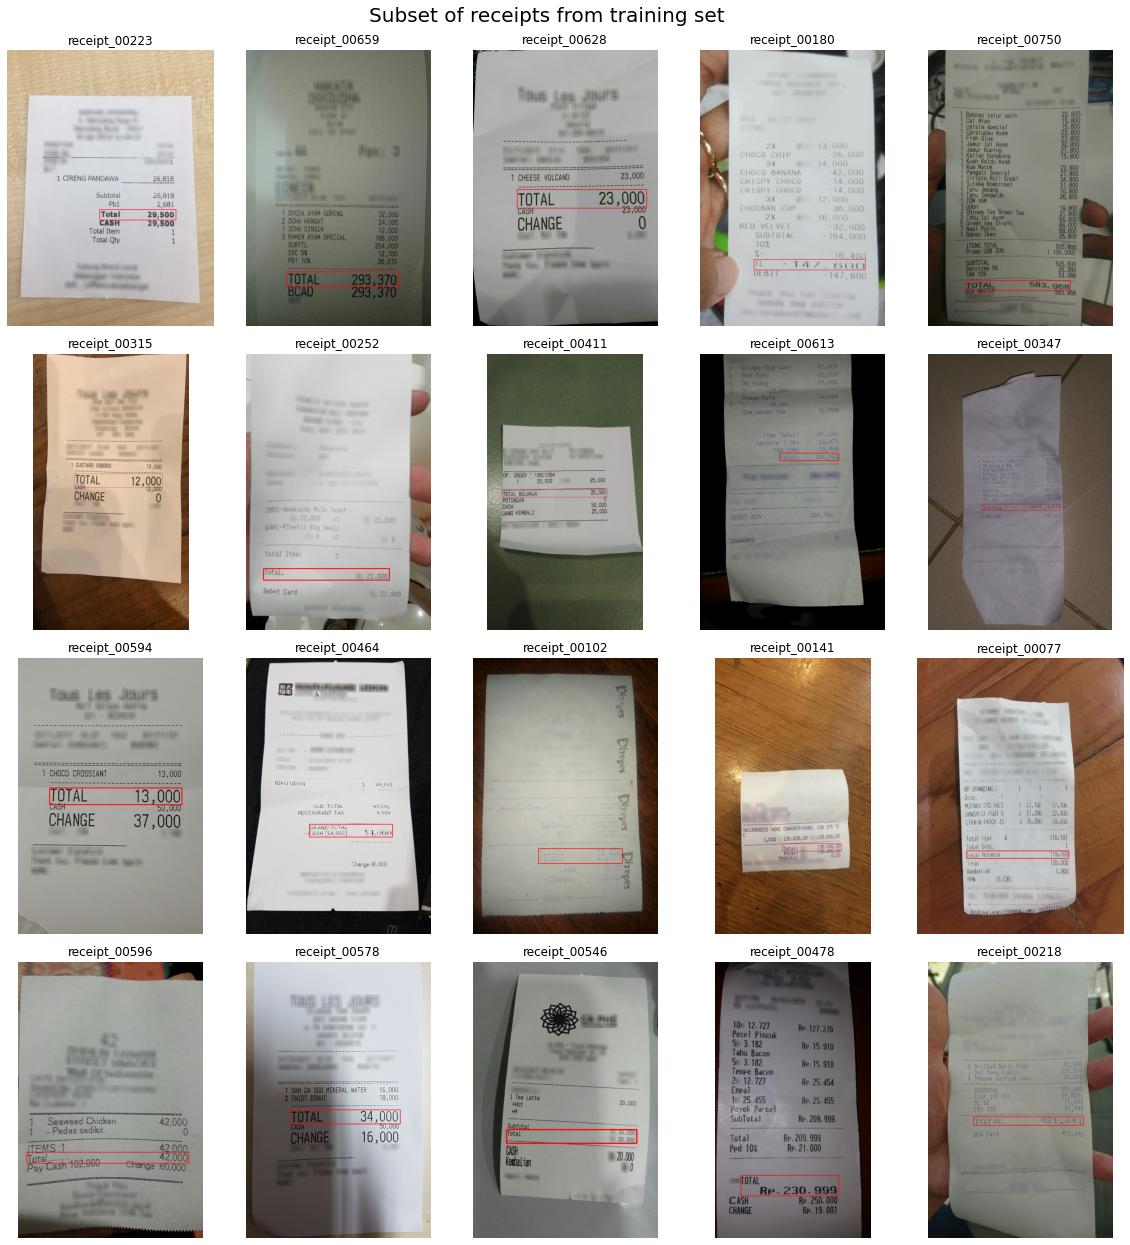

###3 - Building the model 

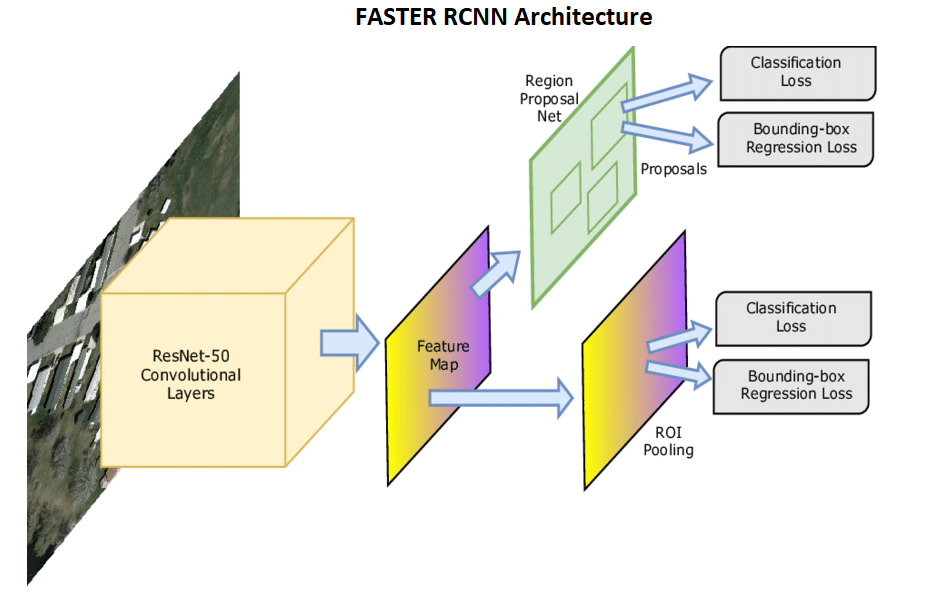

Since the dataset is small training a model from scratch won't give great results so transfer learning is a good alternative that's why i decided to use the pretrained FASTER-RCNN on COCO image segmentation and object detection dataset available in torchvision with a backbone ResNet-50 FPN


In [ ]:
# load the ResNet-50 FPN backbone model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # TTC Bouding Box class and background class

# get number of input features for the classifier (ResNet)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one and create the Fast R-CNN model
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

A dataset wrapper class is necessary for pytorch dataloader that feeds the model the data

In [ ]:
class CORDdataset(torch.utils.data.Dataset):
    """ PyTorch Dataset wrapper for CORD dataset """

    def __init__(self, img_files_paths,target_files_path, img_transform=None, bbox_transform=None):

        self.img_transform = img_transform
        self.bbox_transform = bbox_transform
        self.images_paths = img_files_paths
        self.targets_paths = target_files_path

    def __len__(self):
        return self.images_paths.__len__()

    def __getitem__(self, index):
        if torch.is_tensor(index):
          index = index.tolist()

        image_file_name = self.images_paths[index]
        image_path =self.images_paths[index]
        json_file_path = self.targets_paths[index]
        # get TTC bounding box from JSON
        bbox = extract_bbox_from_json(json_file_path)
        #get image
        image = Image.open(image_path)

        if self.bbox_transform:
            bbox = self.bbox_transform(bbox, original_shape=(image.size[1], image.size[0]))

        if self.img_transform:
            image = self.img_transform(image)

        # create appropriate target format for Faster R-CNN (given by PyTorch documentation)
        target = {}
        target['boxes'] = torch.FloatTensor([bbox])
        target['labels'] = torch.ones((1,), dtype=torch.int64)
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.tensor([(bbox[3] - bbox[1]) * (bbox[2] - bbox[0])])
        target['iscrowd'] = torch.zeros((1,), dtype=torch.int64)

        return image, target


Since the images of the dataset will be resized the corresponding bboxes also needs to be rescaled accordingly

In [ ]:
class BBoxRescale(object):
    """Rescale TTC bounding box"""
    
    def __init__(self, new_shape):
        assert isinstance(new_shape, tuple)
        self.new_shape = new_shape

    def __call__(self, sample, original_shape):
        w_ratio = new_shape[0] / original_shape[0]
        h_ratio = new_shape[1] / original_shape[1]
      
        return [int(sample[0]*h_ratio), int(sample[1]*w_ratio), int(sample[2]*h_ratio), int(sample[3]*w_ratio)]


###4 - Training the model 

The model will be trained on the GPU avaialble on colab first 

The parameters used for the model are : 

-Optimizer: SGD with decay learning rate with initial value of 0.005, a momentum of 0.9 and weight_decay 0.0005 to avoid overfitting.

-Batch size of 8 

-6 epochs




In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

new_shape = (1296, 864) # Image new shape

# image transformer consists of resizing to previous shape and transforming to channel-first format with 0-1 range pixels
img_transform = transforms.Compose([transforms.Resize(size=new_shape),
                                    transforms.ToTensor()])

# TTC bounding box transformer consists of resizing the bounding box according to the new image shape
bbox_transform = BBoxRescale(new_shape=new_shape)


In [ ]:
# use our dataset and defined transformations
dataset = CORDdataset(train_im_files,train_json_files, img_transform=img_transform, bbox_transform=bbox_transform)
dataset_dev = CORDdataset(dev_im_files,dev_json_files, img_transform=img_transform, bbox_transform=bbox_transform)

# define training and validation data loaders
train_data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_dev, batch_size=8, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# push model to selected device
model.to(device)

# construct SGD optimizer 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# construct SGD optimizer the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# train for 6 epochs
num_epochs = 6

for epoch in range(num_epochs):

    # train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


After trainign on 10 epochs ( took about 1 hour and a half ), 6 seems enough and we can obtain fairly good performance as the  loss_box_reg, loss_rpn_box_reg, and recall don't decrease anymore ( the model probably gets stuck in a local minima )

Colab runtime sometimes stop if there's inactivity for a brief period of time so it's best to save the trained model and loaded if the runtime is ever restarded and the GPU is not available 

In [ ]:
#save the model 
PATH='/content/drive/MyDrive/CORD/model'
torch.save(model.state_dict(), PATH)

###5 - Visualize predictions and Post processing 

For the post processing we'll crop the region of the predicted bbox and extract text with pytesseract

Since there is no perfect prediction of the predicted bbox sometimes will miss parts of the text that's why increasing the size of the bbox by a certain percentage ( typically 10% ) will help to capture all the text in the desired region 

The cropped region will be converted to grayscale for better text extraction 

In [ ]:
def increase_bbox(bbox,increase_width=True,increase_height=True,percentage=0.1):
  """ uniformly increase the size of the bbox"""
  width_increase=(bbox[2]-bbox[0])*percentage #the amount of increase on both sides
  height_increase=(bbox[3]-bbox[1])*percentage #the amount of increase on both sides
  xmin,ymin,xmax,ymax=bbox
  if increase_width: #check if we want to increase the width of the bbox
    xmin=bbox[0]-width_increase/2
    xmax=bbox[2]+width_increase/2
  if increase_height: #check if we want to increase the height of the bbox
    ymin=bbox[1]-height_increase/2
    ymax=bbox[3]+height_increase/2
  return[xmin,ymin,xmax,ymax]

In [ ]:
#creating the dataset for inference 
dataset_inference = CORDdataset(test_im_files,test_json_files,img_transform=img_transform, bbox_transform=bbox_transform)
def visualize_prediction(model, dataset, n_rows, n_columns):
    """ visualise n_rows * n_columns model predictions with  bouding boxof  best prediction """
    model.eval() # put model in eval mode

    np.random.seed(20)

    # get random indexes for plotting images
    indexes = np.random.randint(0, len(dataset), n_rows * n_columns)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(17, 20))

    for idx, sample_idx in enumerate(indexes):
        img, true_bb = dataset[sample_idx] # get a random image and its TTC bounding box 
        true_bb = true_bb["boxes"][0]
       
        # predict for an image and copy the result from GPU to CPU
        pred_bbs = model([img.to(device)])[0]['boxes'].detach().cpu().numpy()

        # transform the PyTorch Tensor to PIL format (for matplotlib)
        img = transforms.ToPILImage()(img)
   
        axs[idx // n_columns, idx % n_columns].imshow(img)

        # create a rectangle for the bounding box
        true_bb = Rectangle(xy=(true_bb[0], true_bb[1]), width=true_bb[2] - true_bb[0],
                                height=true_bb[3] - true_bb[1], 
                                linewidth=1, edgecolor='red', facecolor='none', alpha=0.7)

        
        axs[idx // n_columns, idx % n_columns].add_patch(true_bb)
        # get prediction bouding box 
        pred_bb = pred_bbs[0] 
        #extract the total TTC 
        bbox=increase_bbox(pred_bb) #increase the bbox size to capture all the text
        crop=img.crop(bbox) #croping the bbox region to analyze with pytesseract
        crop=ImageOps.grayscale(crop) #converting image to gray scale
        text=pytesseract.image_to_string(crop) #getting the text from the crop
        text=text.split('\n') #spliting the lines of the text
        total=text[-2][-6:]#for simplicity we assume that the last 6 characters represent the price(this does not work on all extracted texts)
  
        axs[idx // n_columns, idx % n_columns].set_title("total amount TTC is "+total)
        pred_bb = Rectangle(xy=(pred_bb[0], pred_bb[1]), width=pred_bb[2] - pred_bb[0],
                                        height=pred_bb[3] - pred_bb[1], 
                                        linewidth=1, edgecolor='blue', facecolor='none', alpha=0.8)

        axs[idx // n_columns, idx % n_columns].add_patch(pred_bb)

        legend_elements = [Patch(facecolor='none', edgecolor='red', 
                                label='GT'),
                          Patch(facecolor='none', edgecolor='blue',
                                label='prediction')]

        axs[idx // n_columns, idx % n_columns].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),loc='upper left')
        axs[idx // n_columns, idx % n_columns].axis('off')
 
    plt.subplots_adjust(wspace=0.45, hspace=0)
    plt.suptitle('Visualization of  predictions', fontsize=20)
    plt.show()      

# visualize predictions
visualize_prediction(model=model, dataset=dataset_inference, n_rows=2, n_columns=3)


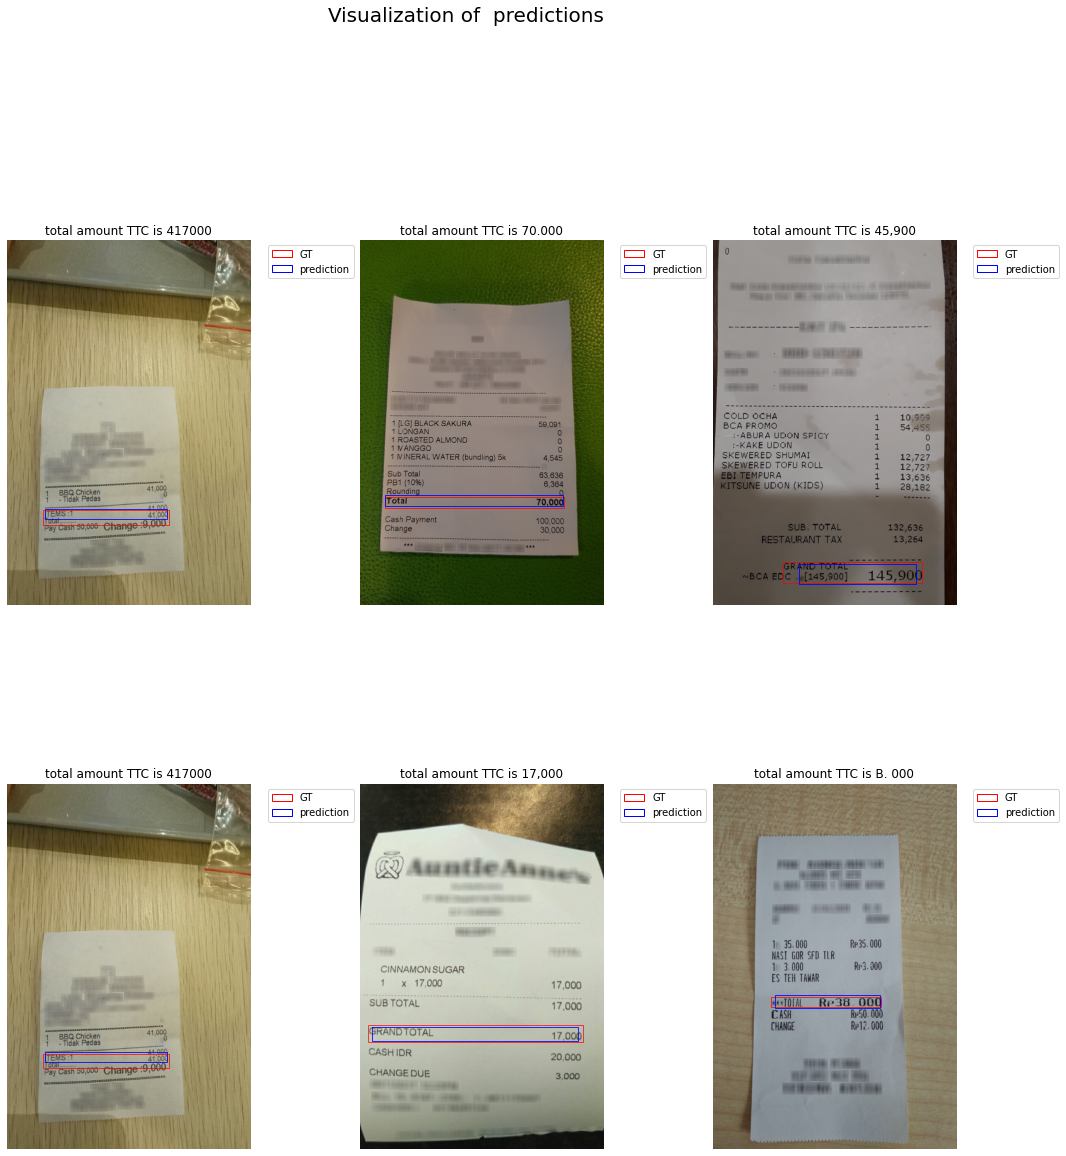

### Conclusion

This notebook can be considered as a **baseline** to extract total amount TTC on receipt image .A pretrained FASTER-RCNN model was trained on the CORD dataset for 6 epochs and good results were obtained . the model is able to localize the wanted region most of the times for reciepts with different resolutions and languages .


*I want to highlight some perspectives to improve the project:*

**->** Instead of feeding the modal colored images we can convert them to binary images using adaptive gaussain thresholing since some receipts have darker parts due to shadow of the person's hands

**->** Enlarge the bounding box by a certain factor 

**->** Try different backbones for the Faster RCNN  model

**->** Try other models like SSD or YOLOv5

**->** Gather more data and train modal from scratch 

**->** Fine tune the modal's hyperparameters to escape local minimas

**->** Improve post processing by debluring the cropped region and make a more generelized way to parse the extracted text and get the total TTC 




